## Import the necessary software libraries:

In [1]:
import os
import torch
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW

from utils import test_policy_network, seed_everything, plot_stats, plot_action_probs
from parallel_env import ParallelEnv, ParallelWrapper

## Create and preprocess the environment

### Create the environment

In [3]:
env = gym.make('CartPole-v0')

/Users/farhan/anaconda3/envs/bmrl/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [4]:
dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: 4. Actions: 2
Sample state: [0.02257555 0.01653313 0.02971248 0.02360531]


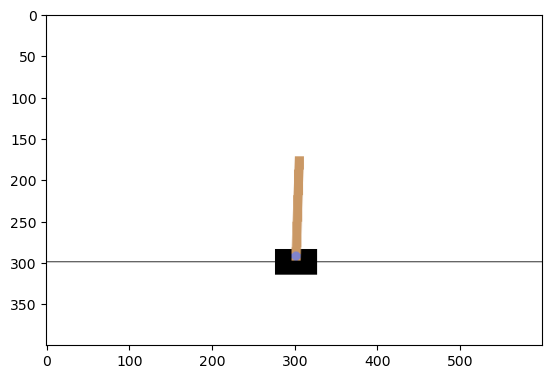

In [5]:
plt.imshow(env.render(mode='rgb_array'))

### Parallelize the environment

In [6]:
num_envs = os.cpu_count()
print(num_envs)

8


In [7]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    seed_everything(env, seed=seed)
    return env

In [8]:
# creating functions that agent can interact with for each parallel environment
env_fns = [lambda: create_env('CartPole-v0', rank) for rank in range(num_envs)]

# [fn, fn, fn]; a list with functions
parallel_env = ParallelEnv(env_fns)

/Users/farhan/anaconda3/envs/bmrl/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [10]:
parallel_env.reset()
# each envir generates a state with 4 dimensions, and we created 8 parallel environments

array([[ 0.02970694, -0.0032065 , -0.01969676, -0.02215744],
       [ 0.02970694, -0.0032065 , -0.01969676, -0.02215744],
       [ 0.02970694, -0.0032065 , -0.01969676, -0.02215744],
       [ 0.02970694, -0.0032065 , -0.01969676, -0.02215744],
       [ 0.02970694, -0.0032065 , -0.01969676, -0.02215744],
       [ 0.02970694, -0.0032065 , -0.01969676, -0.02215744],
       [ 0.02970694, -0.0032065 , -0.01969676, -0.02215744],
       [ 0.02970694, -0.0032065 , -0.01969676, -0.02215744]],
      dtype=float32)

### Prepare the environment to work with PyTorch

In [11]:
class PreprocessEnv(ParallelWrapper):
    
    # parallel wrapper already contains functions to make inputs and outputs usable for parallel environments
    def __init__(self, parallel_env):
        ParallelWrapper.__init__(self, parallel_env)
    
    # override the methods used to interact with the environment
    
    # reset; to reset the parallel env and get the initial observation; 
    # venv is parallel env stored in parallel wrapper
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float() # to get the initial state in form of tensor
    
    # step_async; will take care of executing the actions taken by the agent in each of the environment
    def step_async(self, actions):
        # actions are a column vector and we need a row vector to pass our actions to the parallel environment
        actions = actions.squeeze().numpy() # parallel env works with numpy array
        self.venv.step_async(actions)
    
    # step_wait; will take till each of the environments has processed the action and collect all stuff
    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1) # will return a numpy array with boolean values
        return next_state, reward, done, info
    

In [12]:
parallel_env = PreprocessEnv(parallel_env)

In [15]:
state = parallel_env.reset()
_, reward, done, _ = parallel_env.step(torch.zeros(num_envs, 1, dtype=torch.int32))
print(f"State: {state}")
print(f"Reward: {reward}")
print(f"Done: {done}")

State: tensor([[-0.0285, -0.0340,  0.0113, -0.0456],
        [-0.0285, -0.0340,  0.0113, -0.0456],
        [-0.0285, -0.0340,  0.0113, -0.0456],
        [-0.0285, -0.0340,  0.0113, -0.0456],
        [-0.0285, -0.0340,  0.0113, -0.0456],
        [-0.0285, -0.0340,  0.0113, -0.0456],
        [-0.0285, -0.0340,  0.0113, -0.0456],
        [-0.0285, -0.0340,  0.0113, -0.0456]])
Reward: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
Done: tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])


### Create the policy $\pi(s)$

In [16]:
policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1)
)
# dim=-1; to apply the func to last dimension

### Plot action probabilities

In [17]:
neutral_state = torch.zeros(4) # cart is in centre with angle zero and velocity also zero
left_danger = torch.tensor([-2.3, 0., 0., 0.]) # cart located at left edge of the horizontal axis and if agent moves left, episode will end
right_danger = torch.tensor([2.3, 0., 0., 0.]) # right edge of the horizontal axis

#### Plot a neutral environment

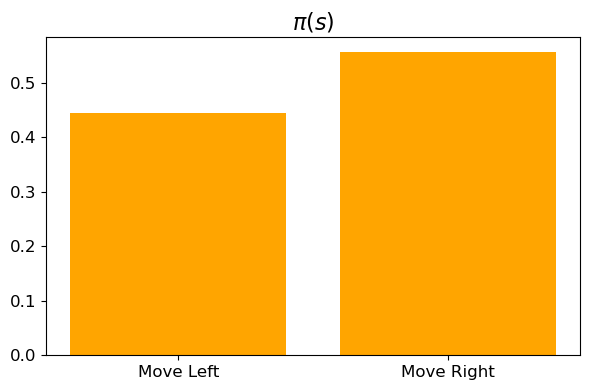

In [21]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right']) # generated by NN with random parameters

#### Plot a state where the cart is too far left

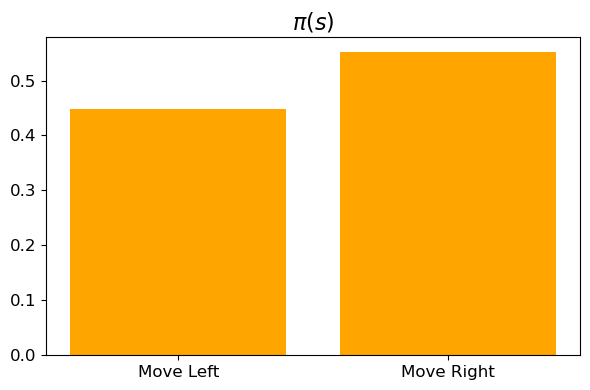

In [25]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right']) 
# bcoz learning process hasn't started yet and these are random values by NN

#### Plot a state where the cart is too far right

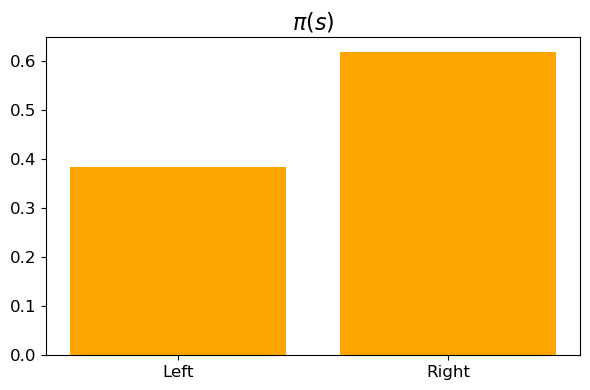

In [26]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

## Implement the algorithm

</br></br>


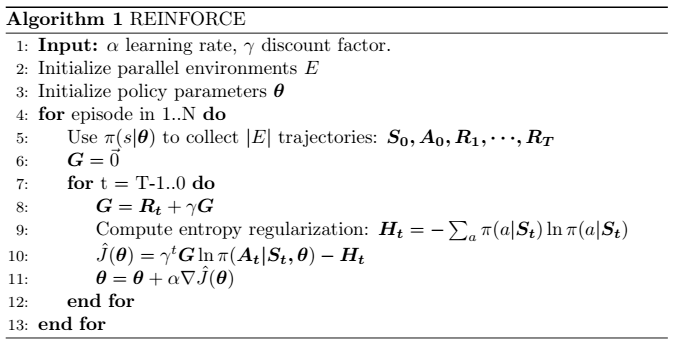

In [27]:
def reinforce(policy, episodes, alpha=1e-4, gamma=0.99):
    
    optim = AdamW(policy.parameters(), lr=alpha)
    stats = {'Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes+1)):
        
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        transitions = []
        ep_return = torch.zeros((num_envs, 1))
        
        while not done_b.all():
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)
            transitions.append([state, action, ~done_b * reward])
            ep_return += reward 
            done_b |= done # logical operation 'or'; to reflect the value of 'done' in done_b column vector
            state = next_state
            
        G = torch.zeros((num_envs, 1))
        
        for t, (state_t, action_t, reward_t) in reversed(list(enumerate(transitions))):
            G = reward_t + gamma * G
            probs_t = policy(state_t)
            log_probs_t = torch.log(probs_t + 1e-6) # added 1e-6 a very small value, so we don't get ln0 error
            action_log_probs_t = log_probs_t.gather(1, action_t)
            
            entropy_t = - torch.sum(probs_t * log_probs_t, dim=-1, keepdim=True)
            gamma_t = gamma ** t
            pg_loss_t = - gamma_t * action_log_probs_t * G
            total_loss_t = (pg_loss_t - 0.01 * entropy_t).mean()
            
            policy.zero_grad()
            total_loss_t.backward()
            optim.step()
            
        stats['Loss'].append(total_loss_t.item())  # item converts pytorch tensor to scalar
        stats['Returns'].append(ep_return.mean().item())
        
    return stats


In [28]:
parallel_env.reset()
stats = reinforce(policy, episodes=200)

100%|█████████████████████████████████████████| 200/200 [00:19<00:00, 10.32it/s]


## Show results

### Show execution stats

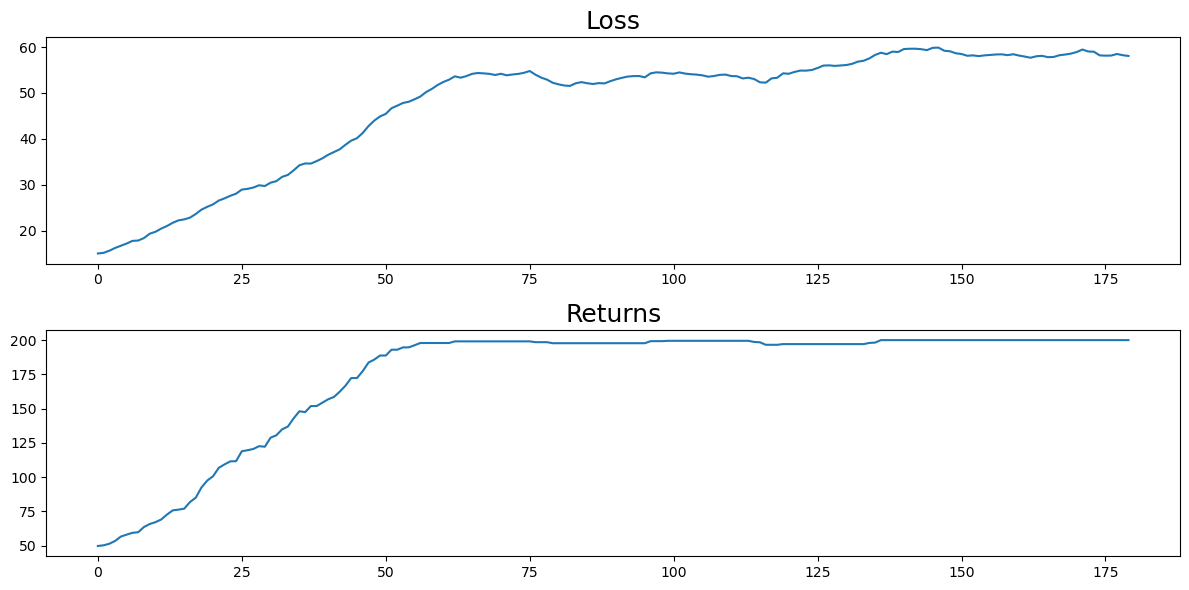

In [29]:
plot_stats(stats)

### Plot action probabilities

#### Plot a neutral environment

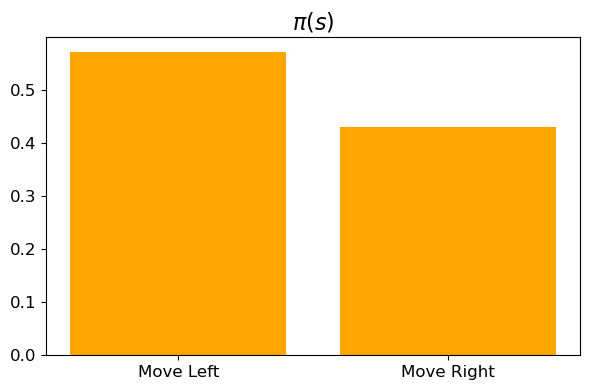

In [30]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far left

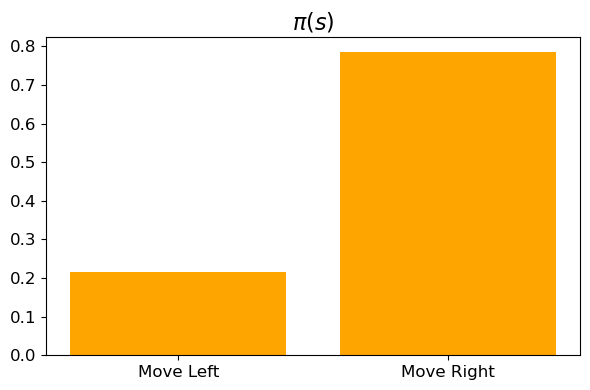

In [31]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far right

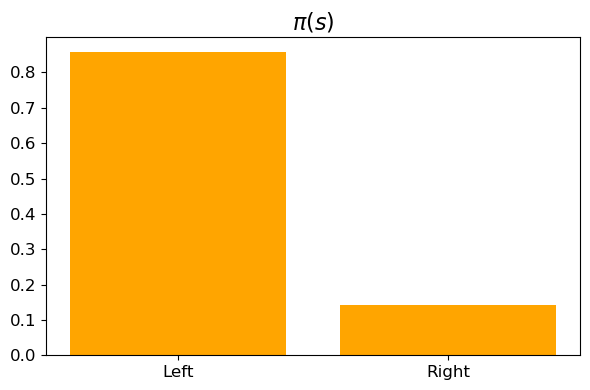

In [32]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

### Test the resulting agent

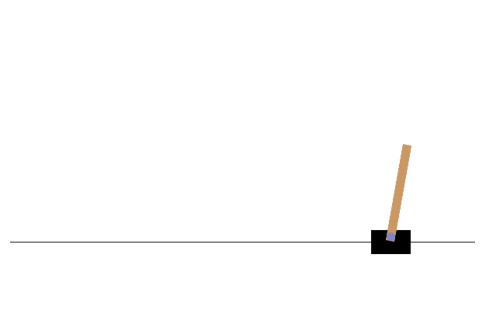

In [33]:
test_policy_network(env, policy, episodes=5)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)